# 3D networks reconstruction

*tysserand* can also reconstruct 3D networks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import napari
from skimage import measure, filters, data
from tysserand import tysserand as ty

## Make a 3D simulated image

In [2]:
# Generate some test data (smooth 3D blob shapes)
np.random.seed(0)
imgarray = filters.gaussian(np.squeeze(np.stack([data.binary_blobs(length=300, n_dim=3, blob_size_fraction=0.1, volume_fraction=0.01)[:, 0:256, 0:256]])).astype(float), sigma=(2.5, 2.5, 2.5))

In [3]:
# Open viewer (Qt window) with axes = slice, row, column
viewer = napari.Viewer(title='volume test', ndisplay=3)
# viewer.add_image(data=imgarray, name='blobs', scale=[256/300, 1, 1], rendering='attenuated_mip', attenuation=2.0, contrast_limits=(0.25, 1))
viewer.add_image(data=imgarray, name='blobs', rendering='attenuated_mip', attenuation=2.0);

We need to define a binary mask related to "segmented" objects, let's inspect intensities first:

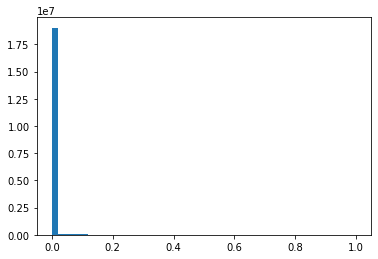

In [4]:
plt.hist(imgarray.ravel(), bins=50);

In [5]:
masks = measure.label(imgarray>0.1, background=0)

## Delaunay triangulation

In [6]:
coords = ty.mask_val_coord(masks)[['x', 'y', 'z']].values
pairs = ty.build_delaunay(coords)
# coords, pairs = ty.refactor_coords_pairs(coords, pairs)
distances = ty.distance_neighbors(coords, pairs)

In [7]:
nodes = ty.coords_to_df(coords)
edges = ty.pairs_to_df(pairs)

In [8]:
# enable multimodalities per node:
MULTI_MOD = False

# it's set at random, don't expect biological insight!
attributes = {'cell_type':['stromal', 'cancer', 'immune'],
              'marker':['PanCK', 'CD8', 'CD4', 'PDL-1', 'CTLA-4']}

nodes_att = pd.DataFrame(data=None, index=np.arange(coords.shape[0]))

if MULTI_MOD:
    for att_name, att_mod in attributes.items():
        att_val = np.random.randint(0, 2, size=(coords.shape[0],len(att_mod))).astype(bool)
        nodes_att = nodes_att.join(pd.DataFrame(att_val, columns=att_mod))
else:
    for att_name, att_mod in attributes.items():
        att_val = np.random.choice(att_mod, coords.shape[0])
        nodes_att = nodes_att.join(pd.DataFrame(att_val, columns=[att_name]))
nodes = nodes.join(nodes_att)
nodes.head()

,x,y,z,cell_type,marker
0,100.841615,39.957887,4.894771,stromal,CD8
1,72.622107,31.288009,10.086823,cancer,CD4
2,180.396258,51.658628,4.636175,stromal,PDL-1
3,7.099235,150.051396,5.142984,cancer,PDL-1
4,6.494898,253.908163,1.704082,cancer,PDL-1


In [9]:
# make colors for nodes
#                 orange      blue      green
class_colors = ['#ff7f0e', '#1f77b4', '#2ca02c']
classes = list(nodes['cell_type'].unique())
dico_col = {classes[0]:class_colors[0],
            classes[1]:class_colors[1],
            classes[2]:class_colors[2]}
colors = []
for cl in nodes['cell_type']:
    colors.append(dico_col[cl])

## Napari 3D network visualization

In [10]:
annotations = ty.make_annotation_dict(
    coords, pairs=pairs,
    nodes_class=nodes['cell_type'],
    nodes_class_color_mapper=dico_col,
)

In [11]:
ty.add_annotations(viewer, annotations)

In [12]:
# Uncomment to save annotations:
# ty.save_annotations('3d_annotations.pkl', viewer=viewer)

## Other reconstruction methods

The 3D (actually N-D) network reconstruction works for other methods!

### k-nearest neighbors reconstruction

In [13]:
pairs = ty.build_knn(coords, k=6)

In [14]:
annotations = ty.make_annotation_dict(
    coords, pairs=pairs,
    nodes_class=nodes['cell_type'],
    nodes_class_color_mapper=dico_col,
)

In [15]:
ty.update_edges(viewer, annotations)

### Contacting areas reconstruction

3D network reconstruction is pretty slow now, I'm working on a solution, coming soon!